# Introduction

In today's world, when disaster strikes, it appears all over social media. Facebook, Twitter, and now, Tiktok typically, floods with posts showing concerns, opinions and various other posts. However, some posts are an outcry for help. The posts are often oversaturated by other posts from people not facing the disaster. So, how can someone find these tweets? That's where machine learning comes into play!

In this project we will create a model that can predict if a tweet is about a real disaster or not.

In [ ]:
#Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Text Cleaning and Manipulation
import spacy
from textblob import TextBlob
import re
import shutil
import string
import itertools
punctuation = string.punctuation

#Text Standardization
from sklearn.feature_extraction.text import CountVectorizer

#Neural Network
import tensorflow as tf
from tensorflow import keras

#Keras Text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Keras NN
from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from IPython.display import Image

In [ ]:
colors = ["black", "orange"]
DATA_PATH = "data/"
train_df = pd.read_csv(DATA_PATH + "train.csv")
test_df = pd.read_csv(DATA_PATH + "test.csv")

# Data Description

Our datasets consist of four predictors:
  - `ID`
  - `keyword`
  - `location`
  - `text`
Our training dataset consists of 7613 observations while our test set contains 3263.

Also, our training dataset has a `target` predictor. Because we have many missing values, and the columns will not help in our model, I am dropping `keyword` and `location` as predictors. However, we will wait to drop `keyword` from the dataset as it could give us some insight when conducting EDA

In [ ]:
print(train_df.shape)
print(train_df["keyword"].isnull().sum())
print(train_df["location"].isnull().sum())
train_df.head(5)

(7613, 5)
61
2533


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print(test_df.shape)
print(test_df["keyword"].isnull().sum())
print(test_df["location"].isnull().sum())
test_df.head(5)

(3263, 4)
26
1105


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.drop(["location"], axis=1, inplace=True)
test_df.drop(["location"], axis=1, inplace=True)

# Cleaning



Here we will perform various text cleaning techniques.

- First, we add *amp* to the stopword list. This was a common word within both disaster and non-disaster tweets. Adding this term will remove a word that is common among both classes.
- Next, I used regex to keep words with a hashtag. When tokenized, spacy would separate the hashtag from the word. Then, our `remove_punctuation` method would remove the hashtag from the string. These hashtags could be key indicators to determine the class of the tweet. Thus, we need to keep the hashtag together.
- Our `lemmatize` function will return the word to its root form. Thus, we decrease the variance of words. Eating and eat will count as the same
- Last, we remove links as they're are not beneficial to our analysis


In [ ]:
#For tokenizing
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
stopwords.add("amp")
example_tweet = "hope I get a new pair of these @Nike shoes!!!! #nikelife https://www.nike.com/launch/t/womens-air-force-1-reveal-pastel-reveal"

#### Add hastags as one whole token instead of separating the hashtag and the word
hasthag_token_match = spacy.tokenizer._get_regex_pattern(nlp.Defaults.token_match)
hashtag_token_match = f"({hasthag_token_match}|#\\w+)"
nlp.tokenizer.token_match = re.compile(hashtag_token_match).match

In [ ]:
def lemmatize(text):
    """Lemmatize the tokens.
    
    Retains more natural word forms than stemming. Brings each word to the appropriate stemming based on the part of speech
    """
    text = text.lower()
    lemmas = []
    tweet = nlp(text)

    for token in tweet:
      lemmas.append(token.lemma_)
    return lemmas
    
def remove_stopwords(tokens):
    """Remove stopwords i.e. words that we do not want within our dataset."""   
    return [ token for token in tokens if token not in stopwords ]

def remove_links(tokens):
    """Removes http/s links from the tokens.
    """
    return [ t for t in tokens
            if not t.startswith("http://")
            and not t.startswith("https://")
        ]

def remove_punctuation(tokens):
    """Remove punctuation from a list of tokens.
    """
    tokens = [t for t in tokens if t not in string.punctuation]
    return tokens

def clean_tweet(text):
  """
  clean a tweet using helper functions
  """
  tokens = lemmatize(text)
  tokens = remove_links(tokens)
  tokens = remove_stopwords(tokens)
  tokens = remove_punctuation(tokens)
  text = " ".join(tokens)
  return text


In [ ]:
#Ex tweet
text = "OMG! I saw him yesterday. Harry's concert was awesome! #WillGoAgain @Christie"
print(clean_tweet(text))

omg I yesterday harry concert awesome #willgoagain @christie


In [ ]:
train_df["text"] = train_df["text"].apply(lambda x: clean_tweet(x))
test_df["text"] = test_df["text"].apply(lambda x: clean_tweet(x))

In [ ]:
train_df.head(5)

,id,keyword,text,target
0,1,NaN,deed reason #earthquake allah forgive,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,resident ask shelter place notify officer evac...,1
3,6,NaN,"13,000 people receive #wildfire evacuation ord...",1
4,7,NaN,got send photo ruby #alaska smoke #wildfire po...,1


# EDA 

### Label Distribution

First, we can see we hace slightly more nondisaster tweets than disaster tweets in our dataset.

([<matplotlib.axis.XTick at 0x7f0469596350>,
 [Text(0, 0, 'Not Disaster'), Text(0, 0, 'Disaster')])

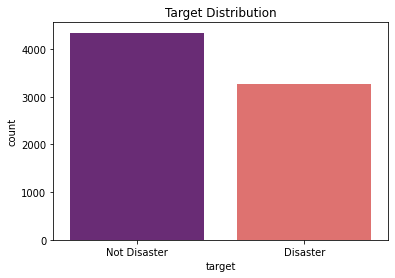

In [ ]:
sns.countplot(x="target", data=train_df, palette="magma")
plt.title("Target Distribution")
plt.xticks([0,1], ["Not Disaster", "Disaster"])

# Top Keywords by Disaster and Nondisaster Tweets

We can see most of the keywords in the `NonDisaster` tweets can be related to multiple other things. For example, *harm* can be used when describing somone injured from a sports injury. Also, *harm* can refer to someone's well being. Other words such as *siren*, *fear* and *explode* can all be words used in both disastorous and nondisastorous situation

On the other hand, keywords in `Disaster` tweets state specific events that would happen in a disaster. Words like *derailment*, *wreckage*, *oil spill*, etc. pertain strictly to disastorous situations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


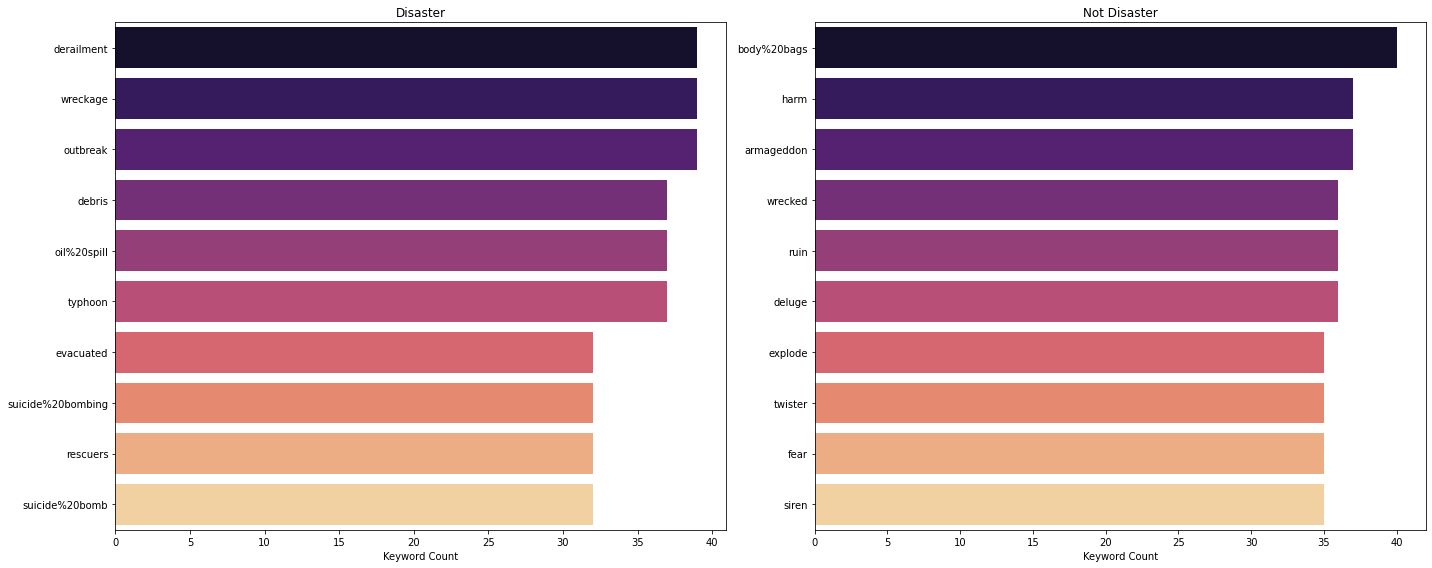

In [ ]:
disaster_keywords = train_df[train_df["target"] == 1]["keyword"].value_counts(ascending=False)
not_disaster_keywords = train_df[train_df["target"] == 0]["keyword"].value_counts(ascending=False)

fig, ax = plt.subplots(1,2, figsize=(20,8))

#Plot for Disaster Keywords
sns.barplot(disaster_keywords[:10], disaster_keywords[:10].index, orient='h', ax=ax[0], palette="magma")
ax[0].set_title("Disaster")
ax[0].set_xlabel("Keyword Count")

#Plot for NonDisaster Keywords
sns.barplot(not_disaster_keywords[:10], not_disaster_keywords[:10].index, orient='h', ax=ax[1], palette="magma")
ax[1].set_title("Not Disaster")
ax[1].set_xlabel("Keyword Count")

plt.tight_layout()
plt.show()

# Length of Tweets

In [ ]:
#Get length of Each Tweet
train_df['tweet_length'] = train_df["text"].apply(len)

disaster_len = train_df[train_df["target"] == 1]
not_disaster_len = train_df[train_df["target"] == 0]

Text(0.5, 0, 'Length')

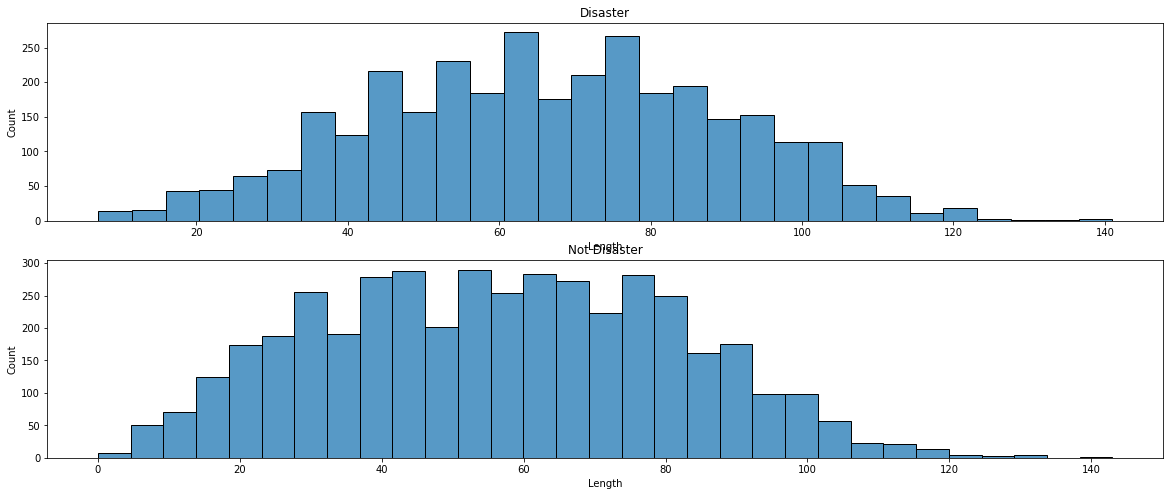

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,8))

sns.histplot(x= disaster_len["tweet_length"], ax=ax[0], palette="magma")
ax[0].set_title("Disaster")
ax[0].set_xlabel("Length")

sns.histplot(x= not_disaster_len["tweet_length"], ax=ax[1], palette="magma")
ax[1].set_title("Not Disaster")
ax[1].set_xlabel("Length")

# Sentiment of Tweets



In [ ]:
#Get Sentiment of Tweets

train_df['polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['subjectivity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

disaster_polarity = train_df[train_df["target"] == 1]
not_disaster_polarity = train_df[train_df["target"] == 0]

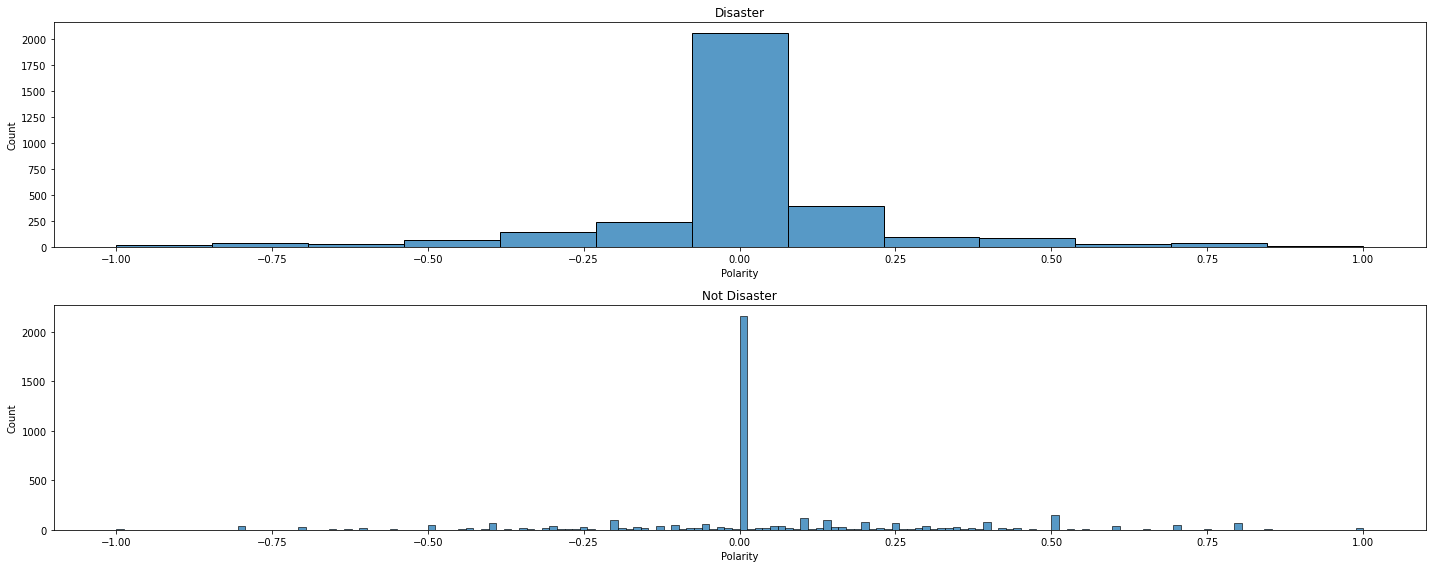

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,8))

sns.histplot(x= disaster_polarity["polarity"], ax=ax[0], palette="magma")
ax[0].set_title("Disaster")
ax[0].set_xlabel("Polarity")

sns.histplot(x= not_disaster_polarity["polarity"], ax=ax[1], palette="magma")
ax[1].set_title("Not Disaster")
ax[1].set_xlabel("Polarity")

plt.tight_layout()

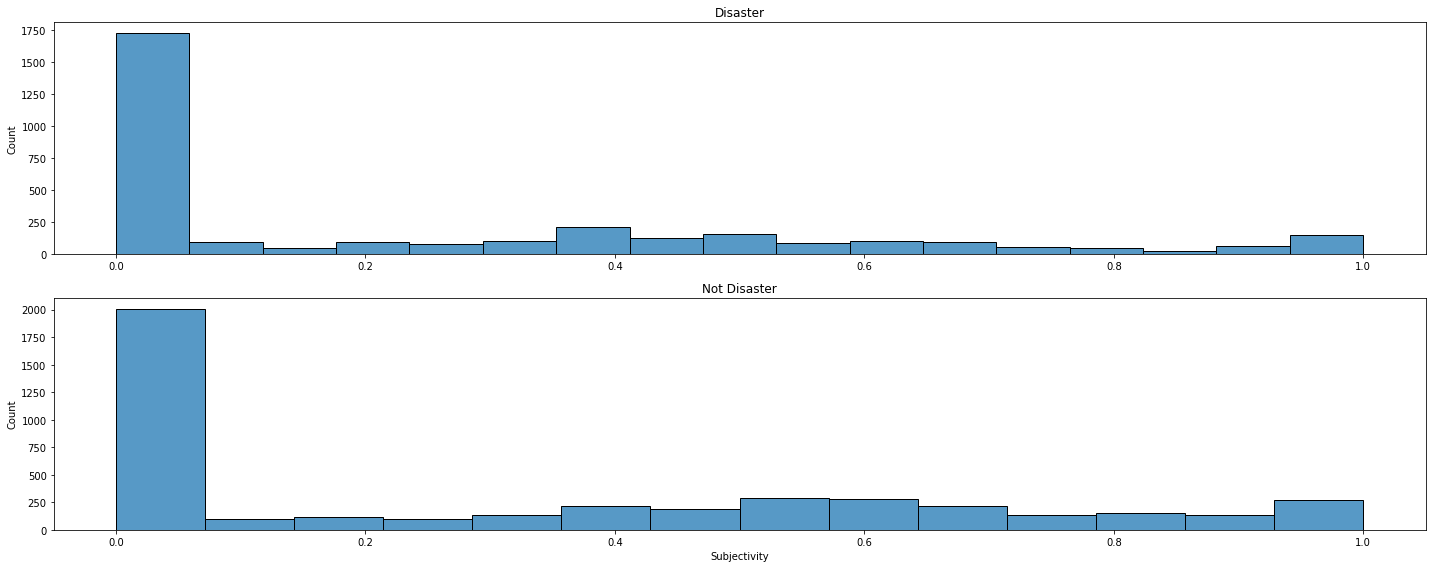

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,8))

sns.histplot(x= disaster_polarity["subjectivity"], ax=ax[0], palette="magma")
ax[0].set_title("Disaster")
ax[0].set_xlabel(None)

sns.histplot(x= not_disaster_polarity["subjectivity"], ax=ax[1], palette="magma")
ax[1].set_title("Not Disaster")
ax[1].set_xlabel("Subjectivity")

plt.tight_layout()

### Bag of Words

Last we would like to use the bag of words technique to see how words appear in different classes of tweets. Essentially, this technique counts the appearance of each word within a given tweet. For example, the sentence *I like peanuts; however, peanuts are as plentiful here* would haave a count of 2 for peanuts within the bag of words technique.

Using this technique, we can see that `fire`, `kill`, `disaster` and `California` are commonly associated with actual disasters. However, the most common words in non-disaster related tweets are `like`, `new`, `body` and `love`. The non-disaster related tweets seems to have common words that are associated with less detrimental cases.

neural networks -> https://www.atmosera.com/blog/text-classification-with-neural-networks/

In [ ]:
test_df.head()

,id,keyword,text
0,0,NaN,happen terrible car crash
1,2,NaN,hear #earthquake different city stay safe
2,3,NaN,forest fire spot pond geese flee street I save
3,9,NaN,apocalypse lighting #spokane #wildfire
4,11,NaN,typhoon soudelor kill 28 china taiwan


In [ ]:
train_df.drop(["keyword", "tweet_length", "polarity", "subjectivity"], axis=1, inplace=True)
test_df.drop(["keyword"], axis=1, inplace=True)
tweets_train = np.array(train_df["text"])
tweets_test = np.array(test_df["text"])
y_train = np.array(train_df["target"])

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 0.005)
X_sparse = vectorizer.fit_transform(tweets_train)

In [ ]:
#Create Dataframe to Plot Top Words
X_names = vectorizer.get_feature_names_out()
X_counts = X_sparse.toarray()
words_train_df = pd.DataFrame(X_counts, columns=X_names)
words_train_df.index = train_df.index
words_train_df['target'] = train_df['target']
words_train_df = words_train_df.groupby('target').mean().transpose()
words_train_df.rename(columns={0 : "Nondisaster", 1:"Disaster"}, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


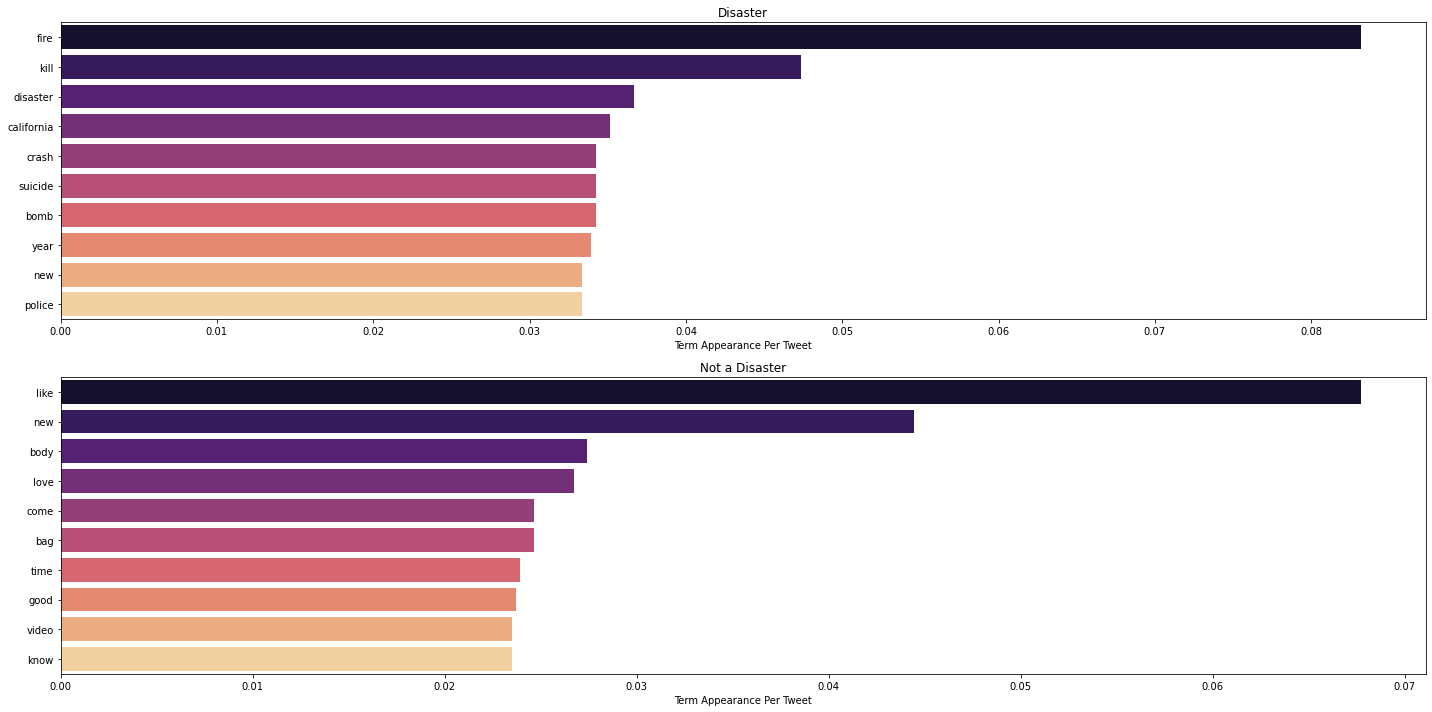

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))

#Top Words in Disaster Tweets
disaster_top_words = words_train_df["Disaster"].sort_values(ascending=False)
sns.barplot(disaster_top_words [:10], disaster_top_words[:10].index, orient='h', ax=ax[0], palette="magma")
ax[0].set_title("Disaster")
ax[0].set_xlabel("Term Appearance Per Tweet")

#Top Words in Non Disaster Tweets
nondisaster_top_words = words_train_df["Nondisaster"].sort_values(ascending=False)
sns.barplot(nondisaster_top_words [:10], nondisaster_top_words[:10].index, orient='h', ax=ax[1], palette="magma")
ax[1].set_title("Not a Disaster")
ax[1].set_xlabel("Term Appearance Per Tweet")

plt.tight_layout()

# Model Building

For many other models such as Linear Discriminant Analysis, or Logistic Regression, we would need to used the *Bag of Words* feature matrix to develop our model. However, for neural networks we can assign each word an assigned id by using the `pad_sequences` function. This allows each tweet to be the same length. Also, each word is assigned a number/index.

Instead of using sparse matrices, such as in the bag of words model, our neural network creates a vector for each word and it's relation to other words and placed, or *embedded* into the feature step. This beginning step is completed within the `embedding layer`. Essentially, a vector is created for each word to describe its relation to all other words within the documents.


Information about the embedding layer can be found [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).  


Also, the information on how text data works within Neural Networks is found [here](https://www.atmosera.com/blog/text-classification-with-neural-networks/)

## Model Testing

We need to test models with different architectures to see which one fits best. We can adjust our hyperparameters once we choose a model with the best structure. Below, we'll test three different architectures and choose the model that words best.

However, for all models we need to makre sure or strings are padded. Our neural network model will struggle if our strings aren't the same length. Therefore, we use padding. Any extra space within this padding is represented by a 0 within the document vector.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_train)

sequences_train = tokenizer.texts_to_sequences(tweets_train)
sequences_test = tokenizer.texts_to_sequences(tweets_test)

padded_sequences_train = pad_sequences(sequences_train)

In [ ]:
sequence_length = len(padded_sequences_train[256])

In [ ]:
num_words = len(tokenizer.word_index) + 1

#Model 1

We need to test models with different architectures to see which architecture would be best for our data.

Our first model will consist of a regular Neural Network with Dense layers.


In [ ]:
model1 = Sequential() 
model1.add(Embedding(num_words, 32, input_length=sequence_length)) 
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(padded_sequences_train, y_train, validation_split = 0.2, epochs=5,
           batch_size=500)

Epoch 1/5
13/13 [==============================] - 1s 36ms/step - loss: 0.6758 - accuracy: 0.5750 - val_loss: 0.6777 - val_accuracy: 0.5384
Epoch 2/5
13/13 [==============================] - 0s 20ms/step - loss: 0.6365 - accuracy: 0.6516 - val_loss: 0.6306 - val_accuracy: 0.6888
Epoch 3/5
13/13 [==============================] - 0s 21ms/step - loss: 0.5312 - accuracy: 0.8149 - val_loss: 0.5583 - val_accuracy: 0.7334
Epoch 4/5
13/13 [==============================] - 0s 19ms/step - loss: 0.3696 - accuracy: 0.8824 - val_loss: 0.4933 - val_accuracy: 0.7728
Epoch 5/5
13/13 [==============================] - 0s 18ms/step - loss: 0.2386 - accuracy: 0.9256 - val_loss: 0.4807 - val_accuracy: 0.7846


# Model 2

# Use Simple RNN

In [ ]:
model2 = Sequential() 
model2.add(Embedding(num_words,64, input_length=sequence_length)) 

model2.add(SimpleRNN(64))
model2.add(Dropout(0.3))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.fit(padded_sequences_train, y_train, validation_split = 0.2, epochs=5,
           batch_size=500)

Epoch 1/5
13/13 [==============================] - 2s 74ms/step - loss: 0.6739 - accuracy: 0.5952 - val_loss: 0.6738 - val_accuracy: 0.5515
Epoch 2/5
13/13 [==============================] - 1s 52ms/step - loss: 0.5812 - accuracy: 0.7514 - val_loss: 0.6247 - val_accuracy: 0.6678
Epoch 3/5
13/13 [==============================] - 1s 56ms/step - loss: 0.4071 - accuracy: 0.8622 - val_loss: 0.5511 - val_accuracy: 0.7308
Epoch 4/5
13/13 [==============================] - 1s 54ms/step - loss: 0.2357 - accuracy: 0.9200 - val_loss: 0.5639 - val_accuracy: 0.7328
Epoch 5/5
13/13 [==============================] - 1s 54ms/step - loss: 0.1480 - accuracy: 0.9512 - val_loss: 0.6004 - val_accuracy: 0.7242


#Model 3: LTSM Model


In [ ]:
model3 = Sequential()

model3.add(Embedding(num_words, 64, input_length=sequence_length)) 

model3.add(LSTM(64, activation="relu"))
model3.add(Dropout(0.4))

model3.add(Dense(32, activation="relu"))
model3.add(Dropout(0.4))

model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #Use return sequences if adding another LSTM

In [ ]:
model3.fit(padded_sequences_train, y_train, validation_split = 0.2, epochs=5)

Epoch 1/5
191/191 [==============================] - 9s 34ms/step - loss: 0.5902 - accuracy: 0.6770 - val_loss: 0.4854 - val_accuracy: 0.7965
Epoch 2/5
191/191 [==============================] - 6s 31ms/step - loss: 0.4704 - accuracy: 0.8575 - val_loss: 0.4549 - val_accuracy: 0.7978
Epoch 3/5
191/191 [==============================] - 6s 31ms/step - loss: 0.2186 - accuracy: 0.9220 - val_loss: 0.7117 - val_accuracy: 0.7597
Epoch 4/5
191/191 [==============================] - 6s 31ms/step - loss: 0.1384 - accuracy: 0.9514 - val_loss: 0.7430 - val_accuracy: 0.7551
Epoch 5/5
191/191 [==============================] - 6s 31ms/step - loss: 0.0949 - accuracy: 0.9678 - val_loss: 1.4707 - val_accuracy: 0.7590


### Model Comparison

Overall, we can see the LSTM model performs the best. This was as expected as LSTM is better at evaluating strings by preventing the vanishing gradient problem. Our LSTM considers all words within the model instead of facoring the parameters towards the end of the recurrent network. However, the data performed well using the simple Dense network model.


Moving forward, I will choose to use `model 3` as it had the best performance. However it did tend to overfit our data (the training accuracy was much higher than the validation accuracy as epochs increased). Thus, we will need to adjust hyperparameters to fix this.

In [ ]:
hist1 = model1.history
hist2 = model2.history
hist3 = model3.history

In [ ]:
def plot_acc(history, axis = None, model=None, ylim=None):
    """ Plots a models validation and training accuracy"""
    axis.plot(history.history['accuracy'], label='accuracy')
    axis.plot(history.history['val_accuracy'], label='val_accuracy')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('accuracy')
    axis.set_title(model)
    axis.set_ylim(ylim)
    axis.legend(loc='lower right')

def plot_val(history, axis=None, model=None):
    "Plot's a models lossat each epoch"
    axis.plot(history.history['loss'], label='loss')
    axis.plot(history.history['val_loss'], label='val_loss')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Loss')
    axis.set_title(model)
    axis.legend(loc='upper right')

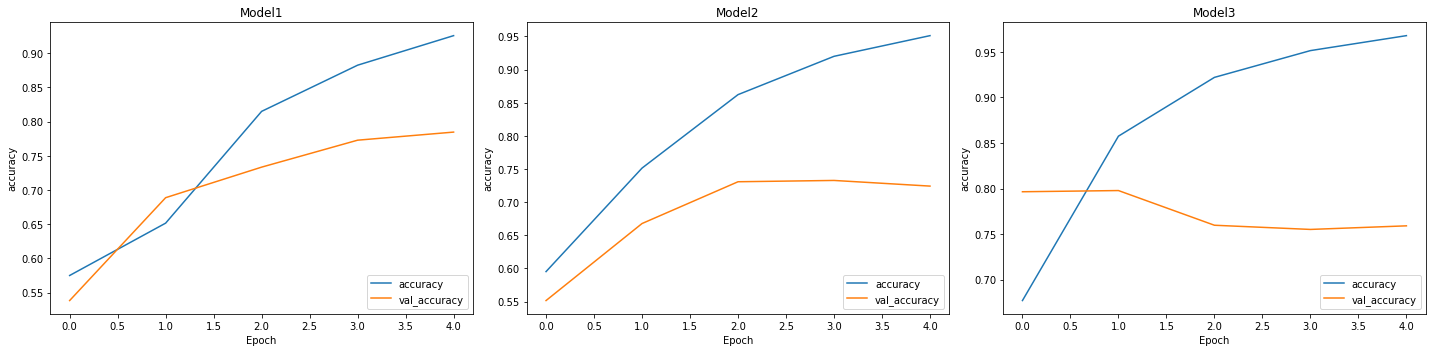

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot_acc(hist1, axis=ax[0], model="Model w/ Dense Layers")
plot_acc(hist2, axis=ax[1], model="Model w/ RNN")
plot_acc(hist3, axis=ax[2], model="Model w/ LSTM")
fig.tight_layout()

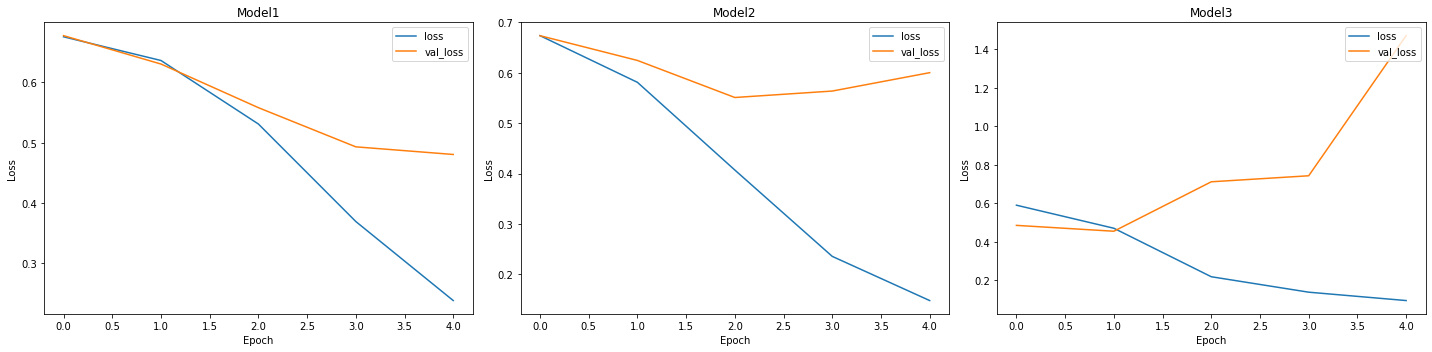

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot_val(hist1, axis=ax[0], model="Model1")
plot_val(hist2, axis=ax[1], model="Model2")
plot_val(hist3, axis=ax[2], model="Model3")
fig.tight_layout()

# Hyperparameter Tuning

In [ ]:
lr_list = [0.001, 0.01]
neuron_count = [(128,64), (64,32), (32, 16)]
dropout_rate = [0.2, 0.3, 0.4]

#lists for metrics
lr_used_list = []
neuron_used = []
dropout_used = []
val_list = []
acc_list = []

for lr in lr_list:
    for neuron in neuron_count:
      for dropout in dropout_rate:
        #Get name of optimizer used

          model3 = Sequential()

          model3.add(Embedding(num_words, neuron[0], input_length=sequence_length)) 

          model3.add(LSTM(neuron[0], activation="relu"))
          model3.add(Dropout(dropout))

          model3.add(Dense(neuron[1], activation="relu"))
          model3.add(Dropout(dropout))

          model3.add(Dense(1, activation='sigmoid'))
          model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
          
          
          #stop model if val_loss begins to increase after 2 consecutive epochs
          es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

          #Fit the model
          model3.fit(padded_sequences_train, y_train, validation_split = 0.2, epochs=5, callbacks=[es])
          
          #Get metrics and store for analysis
          val_loss = max(model3.history.history['val_loss'])
          val_acc = max(model3.history.history['val_accuracy'])


          lr_used_list.append(lr)
          dropout_used.append(dropout)
          neuron_used.append(neuron)
          val_list.append(val_loss)
          acc_list.append(val_acc)

Epoch 1/5
191/191 [==============================] - 14s 67ms/step - loss: 0.7037 - accuracy: 0.6967 - val_loss: 0.4547 - val_accuracy: 0.7951
Epoch 2/5
191/191 [==============================] - 12s 63ms/step - loss: 0.3537 - accuracy: 0.8575 - val_loss: 0.4490 - val_accuracy: 0.8102
Epoch 3/5
191/191 [==============================] - 13s 69ms/step - loss: 0.1945 - accuracy: 0.9279 - val_loss: 0.5625 - val_accuracy: 0.7997
Epoch 4/5
191/191 [==============================] - 12s 63ms/step - loss: 0.1160 - accuracy: 0.9591 - val_loss: 0.8609 - val_accuracy: 0.7735
Epoch 4: early stopping
Epoch 1/5
191/191 [==============================] - 15s 72ms/step - loss: 0.5662 - accuracy: 0.7123 - val_loss: 0.4558 - val_accuracy: 0.7859
Epoch 2/5
191/191 [==============================] - 12s 62ms/step - loss: 0.3127 - accuracy: 0.8760 - val_loss: 0.4800 - val_accuracy: 0.7827
Epoch 3/5
191/191 [==============================] - 13s 70ms/step - loss: 0.1688 - accuracy: 0.9376 - val_loss: 0.581

In [ ]:
tuning_df = pd.DataFrame({"Learning Rate": lr_used_list, "Neuron Combo": neuron_used, "Dropout Used": dropout_used, "Loss": val_list, 
                          "Accuracy": acc_list})
tuning_df.to_csv(DATA_PATH  + "hyperparams")

## Hyperparameter Choice

Overall, the following hyperparamerters had the highest accuracy:
- `Learning Rate`: 0.001
- `Neuron Combo`: (128, 64)
- `Dropout Used`: 0.2

However, the following parameters had a lower validation loss and just a smaller accuracy percentage. We know its best to use the simpler model if the accuracy is similar. Thus, we will use the following hyperparameters due to the simplicity and lower validation loss:
- `Learning Rate`: 0.01
- `Neuron Combo`: (32, 16)
- `Dropout Used`: 0.2

In [ ]:
tuning_df.sort_values(by="Accuracy", ascending=False)

,Learning Rate,Neuron Combo,Dropout Used,Loss,Accuracy
0,0.001,"(128, 64)",0.2,0.860893,0.810243
15,0.010,"(32, 16)",0.2,0.537891,0.804334
11,0.010,"(128, 64)",0.4,1.018653,0.803020
16,0.010,"(32, 16)",0.3,0.608954,0.801707
7,0.001,"(32, 16)",0.3,0.599628,0.800394
2,0.001,"(128, 64)",0.4,0.690114,0.799737
8,0.001,"(32, 16)",0.4,0.781627,0.799081
5,0.001,"(64, 32)",0.4,0.739710,0.797768
14,0.010,"(64, 32)",0.4,0.669758,0.797111
13,0.010,"(64, 32)",0.3,0.656935,0.795141


#Final Model Building

In [ ]:
model3 = Sequential()

model3.add(Embedding(num_words, 32, input_length=sequence_length)) 

model3.add(LSTM(32, activation="relu"))
model3.add(Dropout(0.2))

model3.add(Dense(16, activation="relu"))
model3.add(Dropout(0.2))

model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


#stop model if val_loss begins to increase after 2 consecutive epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

#Fit the model
model3.fit(padded_sequences_train, y_train, validation_split = 0.2, epochs=10, callbacks=[es])

Epoch 1/10
191/191 [==============================] - 8s 22ms/step - loss: 0.6033 - accuracy: 0.6667 - val_loss: 0.4596 - val_accuracy: 0.7859
Epoch 2/10
191/191 [==============================] - 4s 21ms/step - loss: 0.4132 - accuracy: 0.8542 - val_loss: 0.4474 - val_accuracy: 0.8043
Epoch 3/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2505 - accuracy: 0.9105 - val_loss: 0.4977 - val_accuracy: 0.7866
Epoch 3: early stopping


In [ ]:
model3.save(DATA_PATH + "final_model")

# Kaggle Submission and Conclusion

Overall, we received an F1 Score of 0.781 when submitting our model to Kaggle. Our model highly overfit out data. To fix this we could have updated the methods we used. We could have used less neurons. Also, we could have used a simpler model. Also, we could have removed the Dense layer from the model and used only the LSTM layer. All three would have had better validation scores.

Also, we could have tuned our hyperparameters more. This could boost our F1 score a couple percent. In the real world, this is a lot!

In [ ]:
final_model = load_model(DATA_PATH + "final_model")
padded_sequences_test = pad_sequences(sequences_test, maxlen=26 )
predictions = final_model.predict(padded_sequences_test)
predictions = np.array(tf.greater(predictions, 0.5)).astype(int)
predictions = predictions.ravel()
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
test_df.drop("text", axis=1, inplace=True)

In [ ]:
test_df['target'] = list(predictions)

In [ ]:
test_df.to_csv(DATA_PATH + 'test_preds.csv', index = False)

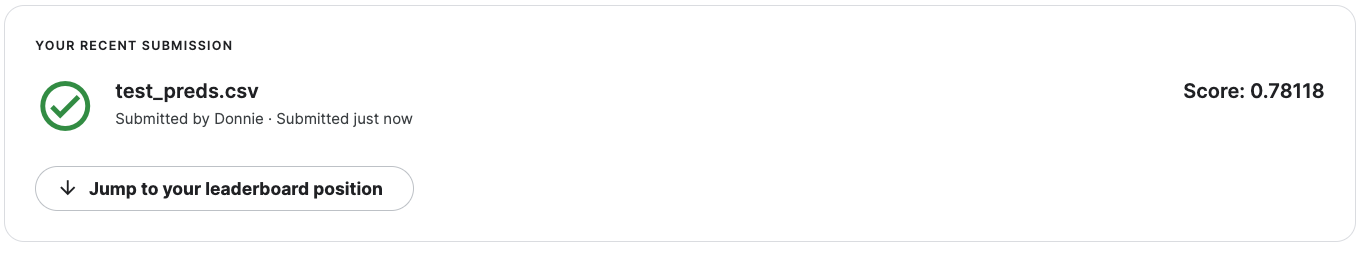

In [ ]:
Image("data/screenshot.png")